<a href="https://colab.research.google.com/github/hy30n80/kaggle/blob/main/Term_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **1. 실험 내용에 대한 전반적 요약**


---

때는 2912년, 사람이 살 수 있는 우주의 다른 행성으로 사람들을 수송하던 우주선 타이타닉이 시 공간 이상과 충돌하는 일이 발생하였는데, 승객 데이터를 기반으로 어떤 승객이 충돌로 인해 다른 차원으로 이동되었는지 여부를 예측하는 모델을 도출하는 것이 목적입니다. 



> **2. 데이터 출처 및 선정한 데이터에 대한 설명**


---

본 데이터는 Kaggle 에서 가져왔으며, 가장 먼저 Kaggle 과 Colab 과 연동시키기 위해서 계정에 json 파일을 kaggle 폴더에 업로드 하는 과정을 거쳤습니다.  
본 Data 는 target feature 을 포함한 14개의 feature로 구성되어 있으며, Training set 에는 8693 개의 Instance 가 있습니다. 

  1. **PassengerId** : 각 승객의 고유 ID ( 각 ID는 ggg_pp 형식을 취하며, 여기서 ggg는 승객이 함께 여행하는 그룹을 나타내며 pp는 그룹 내의 번호 )
  2. **HopePlane** : 승객이 출발한 행성 
  3. **CyroSleep** : 승객이 항해 동안, 동면 하는 것을 선택했는지 여부
  4. **Cabin** : 승객이 머물고 있는 객실 번호 ( 폼 Deck/Num/Side 을 사용하며, 여기서 측면은 좌현의 경우 P 또는 우현의 경우 S가 될 수 있다 )
  5. **Destination** : 승객의 목적지 행성
  6. **Age** : 승객의 나이
  7. **VIP** : 승객이 항해 중 특별 VIP 서비스를 신청했는지 여부
  
  8. **RoomService / FoodCourt /  ShoppingMall / Spa / VRDeck** : 승객이 타이타닉의 각 고급 편의시설에 결제한 금액
  13. **Name** : 승객의 이름과 성
  14. **Transported ( = target)** : 승객이 다른 차원으로 이동되었는지 여부 ( = 예측하려는 대상 ) 



In [1]:
#kaggle 계정 토큰 json file 업로드
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hy30n80","key":"fd641521b37ab39e25b1af679f36e7a4"}'}

In [2]:
# json 파일을 ~/.kaggle 로 이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#캐글에 있는 타이타닉 승객 데이터 다운로드
!kaggle competitions download -c spaceship-titanic

100% 299k/299k [00:00<00:00, 493kB/s]
100% 299k/299k [00:00<00:00, 493kB/s]


In [4]:
#데이터 압축 풀기
!unzip -qq "/content/spaceship-titanic.zip"

In [5]:
# df_test 데이터 셋은 label 이 비어있기 때문에, 이번 과제에서는 df_train 으로만 train, validation, test set 을 구성하였습니다. 
import pandas as pd
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

**캐글에서 불러온 데이터는 df_train 과 df_test 으로 분리되어 있는데, 캐글에서 자체적으로 모델을 평가하기 위한 df_test 은 label 이 비어있기 때문에, df_train 으로만  Train, Validation, Test set 을 따로 구축하기로 하였다. 즉, 이번 과제에서는 캐글 데이터의 df_test 는 함께 전처리만 할 뿐, 학습 및 평가 과정에서 사용하지 않는다.**




> **3. 데이터 확인 및 전처리**

---
1. 데이터 확인

- 14개의 Feature 중에, numeric data는 6개 {Age , Roomservice, FoodCourt, ShoppingMall, Spa, VRDeck} 


- Categorical data 는 8개 {PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name, Transported}

---

2. Feature selection 

- Feature 'Cabin' 하나에 데크, 번호, 좌우현 총 세 가지 속성을 갖고 있기 때문에, 이들을 각기 독립적인 세 가지의 feature 로 분리하였다. 
- Output 과 연관이 없는 feature 인 'PassengerId', 'Name' 삭제하였다.

---

3. 결측값 해결
- Categorical feature 의 결측값은 해당 feature 에서 가장 높은 빈도를 갖는 값으로 대체하였다.
- Numerical feature 의 결측값은 해당 feature 의 중간값으로 대체하였다.

---
4. 데이터 가공
- Numerical feature 의 값들은 각 Feature 의 평균과 표준편차를 각각 고려하여 정규화하였다. (평균 =0 , 분산 = 1 으로 Standardization )
- Categorical feature 의 값들은 원 핫 인코딩을 진행하여 featue 를 확장하였다. 

---
5. 데이터 분할
- Train : Validation : Test = 6 : 2 : 2 로 분할하였다. 

In [8]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
#train, test data 합쳐서 전처리 진행.
data = pd.concat([df_train,df_test], axis=0, ignore_index=True)

#Cabin 안에 3가지 정보가 모여있기 때문에, 3개로 분리하는 과정
data = pd.concat([data, data['Cabin'].str.split('/',expand = True)], axis=1)
data.rename(columns={0: 'Deck', 1:'Num', 2:'Side'}, inplace=True)

#관련 없는 'PassengerId' , 'Name' 삭제, 중복되는 'Cabin' 삭제, Cabin 의 'Num' 은 너무 많은 수를 encoding 해야 하기 때문에 그냥 삭제
#결과적으로는 Cabin 의 Deck, Side 정보만 쓰는 것.
data.drop(columns = ['PassengerId', 'Name', 'Cabin', 'Num'],inplace =True)

data.isna().sum()

HomePlanet       288
CryoSleep        310
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
Deck             299
Side             299
dtype: int64

In [10]:
#각 categorical data 상세 정보
for col in data.columns:
  if data[col].dtype==object:
    print(col,'\b:')
    print(data[col].value_counts(dropna=False))

HomePlanet :
Earth     6865
Europa    3133
Mars      2684
NaN        288
Name: HomePlanet, dtype: int64
CryoSleep :
False    8079
True     4581
NaN       310
Name: CryoSleep, dtype: int64
Destination :
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
NaN               274
Name: Destination, dtype: int64
VIP :
False    12401
NaN        296
True       273
Name: VIP, dtype: int64
Transported :
True     4378
False    4315
NaN      4277
Name: Transported, dtype: int64
Deck :
F      4239
G      3781
E      1323
B      1141
C      1102
D       720
A       354
NaN     299
T        11
Name: Deck, dtype: int64
Side :
S      6381
P      6290
NaN     299
Name: Side, dtype: int64


In [21]:
#categorical feature 의 결측값은 해당 feature 에서 다수를 차지하고 있는 값들로 Replace
data['HomePlanet'].fillna('Earth',inplace=True)
data['CryoSleep'].fillna(False,inplace=True)
data['Destination'].fillna('TRAPPIST-1e',inplace=True)
data['VIP'].fillna(False,inplace=True)
data['Deck'].fillna('F',inplace=True)

#Side 은 결측값 발생한 instance 전의 instance 값으로
data['Side'].fillna(method='ffill',inplace=True)
data['Transported'].fillna(method='ffill',inplace=True)

#numerical feature 의 결측값은 중간값으로 변경
for col in data.columns:
    if data[col].dtype!=object:
        data[col].fillna(data[col].median(),inplace=True)


In [22]:
#Numerical data 의 평균, 표준편차 확인
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.735081,218.378026,441.890979,170.779491,301.722282,300.450270
std,14.238958,641.766201,1568.038076,584.153630,1118.746785,1168.655639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,42.750000,62.750000,23.000000,50.000000,36.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [23]:
#Z-score 를 통한 Numerical 데이터 정규화 과정 / 각 Feature 의 평균과 표준편차를 각각 고려하여 정규화 (평균 =0 , 분산 = 1 으로 Standardization )
data_std = data.copy()
for col in data_std:
  if data_std[col].dtype=='float64':
    data_std[col] = (data_std[col]-data_std[col].mean())/data_std[col].std()

In [24]:
data_std

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,0.720904,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,False,B,P
1,Earth,False,TRAPPIST-1e,-0.332544,False,-0.170433,-0.276072,-0.249557,0.221031,-0.219440,True,F,S
2,Europa,False,TRAPPIST-1e,2.055271,True,-0.273274,1.998745,-0.292354,5.732555,-0.215162,False,A,S
3,Europa,False,TRAPPIST-1e,0.299525,False,-0.340277,0.536409,0.342753,2.705954,-0.091943,False,A,S
4,Earth,False,TRAPPIST-1e,-0.894383,False,0.131858,-0.237170,-0.033860,0.235333,-0.255379,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,0.369755,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,True,G,S
12966,Earth,False,TRAPPIST-1e,0.931593,False,-0.340277,0.258354,-0.263252,-0.260758,-0.133872,True,F,S
12967,Mars,True,55 Cancri e,-0.121854,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,True,D,P
12968,Europa,False,TRAPPIST-1e,-0.121854,False,-0.340277,1.427331,-0.292354,-0.269697,0.190432,True,D,P


In [25]:
# pd.get_dummies() 를 활용한 Categorical feature 원 핫 인코딩
data_std = pd.get_dummies(data_std)

In [26]:
data_std

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,0.720904,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,False,0,...,0,1,0,0,0,0,0,0,1,0
1,False,-0.332544,False,-0.170433,-0.276072,-0.249557,0.221031,-0.219440,True,1,...,0,0,0,0,0,1,0,0,0,1
2,False,2.055271,True,-0.273274,1.998745,-0.292354,5.732555,-0.215162,False,0,...,1,0,0,0,0,0,0,0,0,1
3,False,0.299525,False,-0.340277,0.536409,0.342753,2.705954,-0.091943,False,0,...,1,0,0,0,0,0,0,0,0,1
4,False,-0.894383,False,0.131858,-0.237170,-0.033860,0.235333,-0.255379,True,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,True,0.369755,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,True,1,...,0,0,0,0,0,0,1,0,0,1
12966,False,0.931593,False,-0.340277,0.258354,-0.263252,-0.260758,-0.133872,True,1,...,0,0,0,0,0,1,0,0,0,1
12967,True,-0.121854,False,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,True,0,...,0,0,0,1,0,0,0,0,1,0
12968,False,-0.121854,False,-0.340277,1.427331,-0.292354,-0.269697,0.190432,True,0,...,0,0,0,1,0,0,0,0,1,0


In [27]:
data_std.dtypes

CryoSleep                       bool
Age                          float64
VIP                             bool
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                     bool
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
Deck_A                         uint8
Deck_B                         uint8
Deck_C                         uint8
Deck_D                         uint8
Deck_E                         uint8
Deck_F                         uint8
Deck_G                         uint8
Deck_T                         uint8
Side_P                         uint8
Side_S                         uint8
dtype: object

In [28]:
#CryoSleep, VIP, Transported : boolean -> 0 or 1 변환
for col in data_std.columns:
  if data_std[col].dtype == bool:
    data_std[col] = data[col].astype(int)

In [29]:
data_std

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,0.720904,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,-0.332544,0,-0.170433,-0.276072,-0.249557,0.221031,-0.219440,1,1,...,0,0,0,0,0,1,0,0,0,1
2,0,2.055271,1,-0.273274,1.998745,-0.292354,5.732555,-0.215162,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0.299525,0,-0.340277,0.536409,0.342753,2.705954,-0.091943,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,-0.894383,0,0.131858,-0.237170,-0.033860,0.235333,-0.255379,1,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1,0.369755,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,1,...,0,0,0,0,0,0,1,0,0,1
12966,0,0.931593,0,-0.340277,0.258354,-0.263252,-0.260758,-0.133872,1,1,...,0,0,0,0,0,1,0,0,0,1
12967,1,-0.121854,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,1,0,0,0,0,1,0
12968,0,-0.121854,0,-0.340277,1.427331,-0.292354,-0.269697,0.190432,1,0,...,0,0,0,1,0,0,0,0,1,0


In [30]:
#합쳐 놓았던 데이터를 train, test 분할
train_data = data_std.iloc[:df_train.shape[0],:]
test_data = data_std.iloc[df_train.shape[0]:,:]
print(train_data.shape, test_data.shape)

(8693, 25) (4277, 25)


In [ ]:
#중복된 데이터 처리
"""
train_data.drop_duplicates(inplace=True)
print(train_data.duplicated().sum())
print(train_data.shape, test_data.shape)
"""


In [32]:
#transported -> y 빼주기
train_y = train_data['Transported']
train_x = train_data.drop(columns='Transported')

"""
test_y = test_data['Transported']
test_x = test_data.drop(columns='Transported')
"""

"\ntest_y = test_data['Transported']\ntest_x = test_data.drop(columns='Transported')\n"

In [36]:
# 활용할 데이터를 Train : Validation : Test = 6 : 2 : 2 로 분할
from sklearn.model_selection import train_test_split
X_train, X_med , y_train, y_med = train_test_split(train_x, train_y, train_size = 0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_med, y_med, test_size = 0.50, shuffle=True)

In [37]:
print(X_train.shape, X_val.shape, X_test.shape)

(5215, 24) (1739, 24) (1739, 24)


In [38]:
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
3959,0,0.018605,0,-0.282623,-0.281811,-0.006470,0.273769,-0.257091,1,0,...,0,0,0,0,0,0,1,0,1,0
6337,1,1.212513,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,0,1,0,0,1
5528,1,-0.121854,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,0,1,0,0,1
5205,0,-0.051625,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,0,0,...,0,0,0,0,0,1,0,0,1,0
3648,0,-0.753923,0,-0.192248,-0.281811,-0.292354,-0.258077,0.275145,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,1,-0.332544,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,1,0,0,1,0
883,0,-0.683693,0,-0.228086,-0.278623,-0.292354,0.036003,-0.096222,1,0,...,0,0,0,0,0,1,0,0,1,0
772,0,0.861364,0,1.543587,-0.281811,-0.292354,-0.269697,0.455694,0,0,...,0,0,0,0,0,1,0,0,0,1
1185,0,-0.121854,0,1.649545,-0.281811,-0.290642,-0.260758,-0.249389,0,0,...,0,0,0,0,1,0,0,0,0,1




> **4. 모델 구축**



---



      4-0. 참고 BaseLine (0-R, 1-R, NB Classifier)
      4-1. Decision Tree 
      4-2. Perceptron
      4-3. MLP 
      4-4. KNN Classifier
      4-5. Ensemble model 





In [47]:
# 참고 BaseLine 1. 0-R
print(y_train.value_counts(sort=False))
print('Zero-R train accuracy : ', max(y_train.value_counts(sort=False)[0], y_train.value_counts(sort=False)[1]) / y_train.shape[0])

0    2618
1    2597
Name: Transported, dtype: int64
Zero-R train accuracy :  0.5020134228187919


**Feature를 고려하지 않고, train 의 label 의 분포 비율을 통한 0-R 정확도가  0.502 가 나왔다. Label 의 0,1 분포가 거의 비슷하다는 점을 시사한다. 앞으로 어떤 모델을 구상하던, 당연히 이 수치보다는 높게 나와야 하는 Baseline 이다.**

In [45]:
# 참고 BaseLine 2. 1-R
from collections import Counter
import numpy as np
total_errors = []

xy_train = pd.concat([X_train, y_train], axis=1)
for col in xy_train.columns[:-1]:
  error = 0
  for val in xy_train[col].unique():
    length = len(xy_train[xy_train[col] == val])
    # print(f"{col} : {val}, length : {length}")
    error += (length - Counter(xy_train[xy_train[col] == val]['Transported']).most_common()[0][1])
  total_errors.append(error)

best_feature = xy_train.columns[np.argmin(total_errors)]
print(total_errors)
print(best_feature)
print("accuracy of ",best_feature, " is ",1-np.min(total_errors)/xy_train.shape[0])

[1481, 2244, 2592, 1611, 1636, 1702, 1587, 1637, 2185, 2199, 2583, 2370, 2575, 2348, 2597, 2379, 2437, 2583, 2431, 2409, 2557, 2597, 2308, 2308]
CryoSleep
accuracy of  CryoSleep  is  0.7160115052732503


In [53]:
print(Counter(xy_train[xy_train['CryoSleep'] == 0]['Transported']))
print(Counter(xy_train[xy_train['CryoSleep'] == 1]['Transported']))

Counter({0: 2274, 1: 1137})
Counter({1: 1460, 0: 344})


In [62]:
val_predict = []

for c in X_val['CryoSleep']:
  if c == 0 : 
    val_predict.append(0)
  else: 
    val_predict.append(1)

val_actual = list(y_val)
errors = 0
for i in range(len(val_actual)):
  if val_predict[i]!=val_actual[i]:
    errors +=1
      
print(1 - errors / len(val_actual))



0.7170787809085681


**Train set 을 기반으로, 1-R 을 진행하였을 때 여러 Feature 들 중에서, 'CryoSleep' 을 기준으로 결정을 내릴 때 가장 높은 정확도를 나타낸다는 것을 알 수 있다. 다른 Feature 들을 아무것도 고려하지 않고, 오로지 'CryoSleep' == 0 일 때는 Transported =0 을 반환하고, 'CryoSleep' == 1 일 때에는 Transported = 1을 반환한다고 했을 때 정확도가 0.716 이라는 점이다. 이는 0-R 보다 훨씬 개선된 수치이며, 후에 나올 여러 모델의 최소한의 Baseline 정확도가 될 것 이다. 실제로, CryoSleep 을 기준으로 validation set 에 적용해보았을 때도, 0.717 정확도가 나온다는 것을 알 수 있다.**

In [63]:
# 참고 BaseLine 3, NaiveBayesian Classifier
from sklearn.naive_bayes import GaussianNB
model_NB = GaussianNB()

#Gaussian Naive Bayesian Classifier을 fit합니다.
model_NB.fit(X_train, y_train)

#두 데이터에 대하여 score를 출력합니다.
score_NB = model_NB.score(X_val,y_val)
predict_NB = model_NB.predict(X_val)
print(f'score : {score_NB}')
print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (predict_NB != y_val).sum()))


score : 0.723404255319149
Number of mislabeled points out of a total 1739 points : 481


**NaiveBeyesian Classifier 을 사용하였을 때, Validation data set 에 대한 정확도가 0.723 이 나왔다**

In [64]:
#1-1. Decision Tree - 기본

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("train score", dt.score(X_train, y_train))
print("validation score", dt.score(X_val, y_val))


train score 0.9520613614573347
test score 0.738355376653249


**어떠한 parameter 를 변경하지 않고, Decision Tree 를 사용하였을 때에 Train score 는 0.952, validation score 는 0.738 이 나왔다. 전반적으로 판단했을 때, training data set에 overfitting 되어 있는 경향이 강하다고 판단했기 때문에, DT 에 관한 parameter tuning 을 진행하기로 하였다.**

In [72]:
#1-2. Decision Tree - parameter tuning

# max leaf nodes 변경
dt1 = DecisionTreeClassifier(max_leaf_nodes = 20)
dt1.fit(X_train, y_train)

# max_depth 변경 
dt2 = DecisionTreeClassifier(max_depth = 5)
dt2.fit(X_train, y_train)

# min sample split
dt3 = DecisionTreeClassifier(min_samples_split = 9)
dt3.fit(X_train, y_train)

# min sample leaf 
dt4 = DecisionTreeClassifier(min_samples_leaf = 13)
dt4.fit(X_train, y_train)

# min_impurity decrease 
dt5 = DecisionTreeClassifier(min_impurity_decrease = 0.001)
dt5.fit(X_train, y_train)


print('Original DT : ', dt.score(X_val, y_val))
print('max_leaf_nodes = 20, DT : ', dt1.score(X_val, y_val))
print('max_depth = 5, DT : ', dt2.score(X_val, y_val))
print('min_samples_split = 9, DT : ', dt3.score(X_val, y_val))
print('min_samples_leaf = 13, DT : ', dt4.score(X_val, y_val))
print('min_impurity_decrease = 0.001, DT : ', dt5.score(X_val, y_val))

Original DT :  0.738355376653249
max_leaf_nodes = 20, DT :  0.7849338700402531
max_depth = 5, DT :  0.7648073605520413
min_samples_split = 9, DT :  0.7515813686026452
min_samples_leaf = 13, DT :  0.7849338700402531
min_impurity_decrease = 0.001, DT :  0.7912593444508338


**Decision Tree 의 여러 pruning 방법을 시도해 보았고, 여러 시행착오를 거치면서 각 parameter 에서 높은 정확도를 나타내는 수치를 발견하였다. 그 중 min_impurity_decrease 를 0.001 으로 했을 때 validation score 가 0.791 로 가장 높은 정확도를 보였고, 그 뒤로는 max_leaf_nodes =20 혹은 min_samples_leaf = 13 으로 train set 에 관한 Decision Tree 를 만들었을 때 validation score 가 0.785 로 초반 DT 에 비하여 괄목할 만한 높은 정확도를 보였다.**

In [186]:
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
3959,0,0.018605,0,-0.282623,-0.281811,-0.006470,0.273769,-0.257091,1,0,...,0,0,0,0,0,0,1,0,1,0
6337,1,1.212513,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,0,1,0,0,1
5528,1,-0.121854,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,0,1,0,0,1
5205,0,-0.051625,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,0,0,...,0,0,0,0,0,1,0,0,1,0
3648,0,-0.753923,0,-0.192248,-0.281811,-0.292354,-0.258077,0.275145,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,1,-0.332544,0,-0.340277,-0.281811,-0.292354,-0.269697,-0.257091,1,0,...,0,0,0,0,0,1,0,0,1,0
883,0,-0.683693,0,-0.228086,-0.278623,-0.292354,0.036003,-0.096222,1,0,...,0,0,0,0,0,1,0,0,1,0
772,0,0.861364,0,1.543587,-0.281811,-0.292354,-0.269697,0.455694,0,0,...,0,0,0,0,0,1,0,0,0,1
1185,0,-0.121854,0,1.649545,-0.281811,-0.290642,-0.260758,-0.249389,0,0,...,0,0,0,0,1,0,0,0,0,1


In [233]:
#1-3. Decision Tree - Feature selection 적용

print(X_train.shape)
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier(min_samples_leaf = 13)

## 24개의 Feature 중, 가장 중요도 높은 7개의 feature 으로만 활용한 model 의 validation score
selector_1 = RFE(clf, n_features_to_select=7, step=1)
selector_1 = selector_1.fit(X_train, y_train)

clf.fit(X_train.iloc[:,selector_1.support_], y_train)
print(clf.score(X_val.iloc[:,selector_1.support_], y_val))

(5215, 24)
0.7722829212190915


In [248]:
# 24개의 Feature 중, 가장 중요도 높은 10개의 feature 으로만 활용한 model 의 validation score

selector_2 = RFE(clf, n_features_to_select=10, step=1)
selector_2 = selector_2.fit(X_train, y_train)

clf.fit(X_train.iloc[:,selector_2.support_], y_train)
print(clf.score(X_val.iloc[:,selector_2.support_], y_val))

0.765382403680276


In [235]:
# 24개의 Feature 중, 가장 중요도 높은 13개의 feature 으로만 활용한 model 의 validation score

selector_3 = RFE(clf, n_features_to_select=13, step=1)
selector_3 = selector_3.fit(X_train, y_train)

clf.fit( X_train.iloc[:,selector_3.support_], y_train)
print(clf.score(X_val.iloc[:,selector_3.support_], y_val))

0.7826336975273146


In [256]:
# 24개의 Feature 중, 가장 중요도 높은 17개의 feature 으로만 활용한 model 의 validation score

selector_4 = RFE(clf, n_features_to_select=17, step=1)
selector_4 = selector_4.fit(X_train, y_train)

clf.fit(X_train.iloc[:,selector_4.support_], y_train)
print(clf.score(X_val.iloc[:,selector_4.support_], y_val))

0.7866589994249569


In [252]:
# 24개의 Feature 중, 가장 중요도 높은 21개의 feature 으로만 활용한 model 의 validation score

selector_5 = RFE(clf, n_features_to_select=21, step=1)
selector_5 = selector_5.fit(X_train, y_train)

clf.fit(X_train.iloc[:,selector_5.support_], y_train)
print(clf.score(X_val.iloc[:,selector_5.support_], y_val))

0.7849338700402531


In [257]:
print(selector_4.support_)

[ True  True False  True  True  True  True  True  True  True False False
  True  True  True False  True False  True  True  True False  True False]


**n_features_to_select=10 인 Decision Tree 의 성능 validation score 는 0.7849 였으며, Feature selection 을 통해 더 높일 수 있다고 생각하였다. 실제로 원하는 개수의 변수들이 남을 때까지 학습을 반복하며 유의미하지 않은 변수들을 제거해나가는 Backward 방식인 RFE 방식을 사용하였는데, 24개의 feature 중 17개의 feature 들만 사용하여 모델을 구축하고 평가했을 때 0.7867 으로 작은 폭이지만, 성능이 증가한 모습을 확인할 수 있었다.
이에 관한 원인으로, 현재 7개의 삭제된 feature 가 대부분 Deck 에 관련한 것이였는데 아무래도 Deck 에 관한 feature 가 하나의 Feature 에서 원 핫 인코딩을 통해 8가지의 Feautre 로 분할되면서 분류 기준으로서 분별 영향력이 줄어들었기 때문이라고 생각한다.**  

In [83]:
#2-1. Perceptron - (iter=10) 
from sklearn.linear_model import Perceptron

model_perceptron_1 = Perceptron(max_iter=10)
model_perceptron_1.fit(X_train, y_train)

print("train score", model_perceptron_1.score(X_train, y_train))
print("validation score", model_perceptron_1.score(X_val, y_val))

train score 0.6632790028763184
validation score 0.6503737780333525


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [84]:
#2-2. Perceptron - (iter = 100) 
from sklearn.linear_model import Perceptron

model_perceptron_2 = Perceptron(max_iter=100)
model_perceptron_2.fit(X_train, y_train)

print("train score", model_perceptron_2.score(X_train, y_train))
print("validation score", model_perceptron_2.score(X_val, y_val))

train score 0.7018216682646213
validation score 0.718803910293272


In [85]:
#2-3. Perceptron - (iter = 1000)
from sklearn.linear_model import Perceptron

model_perceptron_3 = Perceptron(max_iter=1000)
model_perceptron_3.fit(X_train, y_train)

print("train score", model_perceptron_3.score(X_train, y_train))
print("validation score", model_perceptron_3.score(X_val, y_val))

train score 0.7018216682646213
validation score 0.718803910293272


**Perceptron 을 기반으로 모델을 구축해보았다. max_iter 을 10, 100, 1000 으로 각기 달리하여 3가지의 perceptron 을 만들어보았는데, 처음 max_iter = 10 일 때 validation score 가 약 0.65 정도의 낮은 정확도를 보였는데, train score 도 비슷한 수치의 정확도였기 때문에 모델의 문제가 overfitting 이 아닌, underfitting 이라는 점을 알 수 있었다. 따라서, iteration 을 100, 1000 으로 늘렸지만 더 이상 학습하지 못하고 정확도가 올라가지 않는다는 점을 확인할 수 있었고, 최종적으로 perceptron 의 구조는 0.719 정확도에서 멈춘다는 사실을 알게 되었다. 이는 위에서 진행한 1-R 의 0.717 과 거의 비슷한 정도였다.**

In [113]:
# epoch 에 따른 accuracy 를 시각화하는 plot 함수
import matplotlib.pyplot as plt

def plot(results):
  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [104]:
#3-1. MLP (Multilayer perceptron)
import tensorflow as tf

MLP_1 = tf.keras.models.Sequential([
	tf.keras.layers.Dense(16, input_shape=(24,), activation='relu'),
	tf.keras.layers.Dense(8, activation='relu'), 
	tf.keras.layers.Dense(1, activation='sigmoid'), 
])

MLP_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                400       
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [105]:
MLP_1.compile(tf.keras.optimizers.RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history_MLP_1 = MLP_1.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


163/163 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6439 - val_loss: 0.5411 - val_accuracy: 0.7516
Epoch 2/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4957 - accuracy: 0.7613 - val_loss: 0.4493 - val_accuracy: 0.7872
Epoch 3/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4484 - accuracy: 0.7845 - val_loss: 0.4281 - val_accuracy: 0.8022
Epoch 4/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4345 - accuracy: 0.7904 - val_loss: 0.4200 - val_accuracy: 0.8028
Epoch 5/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4277 - accuracy: 0.7918 - val_loss: 0.4164 - val_accuracy: 0.7993
Epoch 6/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4230 - accuracy: 0.7952 - val_loss: 0.4153 - val_accuracy: 0.7987
Epoch 7/100
163/163 [==============================] - 1s 4ms/step - loss: 0.4189 - accuracy: 0.7988 - val_loss: 0.4131 - val_accuracy: 0.8016
Epoch 8/100

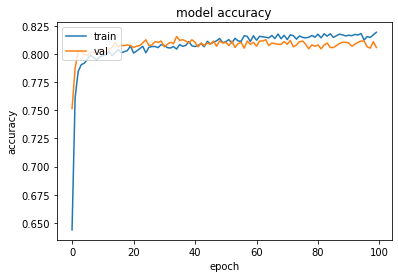

In [114]:
plot(history_MLP_1)

**MLP_1 모델은 hidden layer 2개로 모델을 쌓았고, Optimizer 는 RMSprop 으로 learning rate 는 0.001 로 구성하였다. 그 결과, validation accuracy 가 0.81 대까지 올라온 모습을 확인할 수 있었다. 물론 높은 수치였지만, training accuracy 가 validation accuracy 와 비슷한 0.81 대의 수치였기 때문에, 만약 training set 에 조금 더 fitting 된다면 validation accuracy 가 더 높아질 수 있을 것이라는 기대가 생겼고, 2번째 MLP_2 모델은 더 깊게, epochs 수를 늘리기로 결정하였다.**

In [107]:
#3-2. MLP (Multilayer perceptron)
import tensorflow as tf

MLP_2 = tf.keras.models.Sequential([
	tf.keras.layers.Dense(64, input_shape=(24,), activation='relu'), 
  tf.keras.layers.Dense(32, activation = 'relu'),
  tf.keras.layers.Dense(16, activation = 'relu'),
	tf.keras.layers.Dense(8, activation='relu'), 
	tf.keras.layers.Dense(1, activation='sigmoid'), 
])

MLP_2.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                1600      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 16)                528       
                                                                 
 dense_30 (Dense)            (None, 8)                 136       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [108]:
MLP_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history_MLP_2 = MLP_2.fit(X_train,y_train,epochs=300,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/300


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


163/163 [==============================] - 2s 5ms/step - loss: 0.5121 - accuracy: 0.7628 - val_loss: 0.4277 - val_accuracy: 0.7959
Epoch 2/300
163/163 [==============================] - 1s 5ms/step - loss: 0.4341 - accuracy: 0.7839 - val_loss: 0.4190 - val_accuracy: 0.7999
Epoch 3/300
163/163 [==============================] - 1s 4ms/step - loss: 0.4208 - accuracy: 0.7931 - val_loss: 0.4227 - val_accuracy: 0.7890
Epoch 4/300
163/163 [==============================] - 1s 4ms/step - loss: 0.4136 - accuracy: 0.7987 - val_loss: 0.4161 - val_accuracy: 0.8010
Epoch 5/300
163/163 [==============================] - 1s 4ms/step - loss: 0.4077 - accuracy: 0.8006 - val_loss: 0.4070 - val_accuracy: 0.7987
Epoch 6/300
163/163 [==============================] - 1s 4ms/step - loss: 0.4046 - accuracy: 0.8019 - val_loss: 0.4160 - val_accuracy: 0.8039
Epoch 7/300
163/163 [==============================] - 1s 4ms/step - loss: 0.4029 - accuracy: 0.8012 - val_loss: 0.4091 - val_accuracy: 0.8062
Epoch 8/300

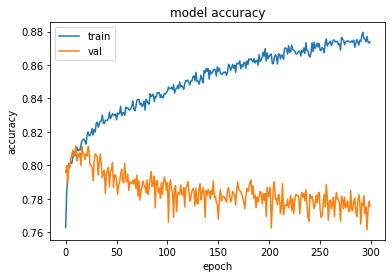

In [115]:
plot(history_MLP_2)

**MLP_1 모델이 충분히 학습되지 않고, underfitted 되어있다고 판단하였기 때문에 MLP_2 에서는 hidden layer 수를 4개로 증가시켰으며, training set 에 조금 더 fitting 하기 위하여 epochs 수를 300 으로 늘렸다. 그 결과, train accuracy 는 증가했지만, validation accuracy 는 epoch 수가 증가할 수록 감소하는 overfitting 모습을 보였다. 처음에는 layer 를 깊게 쌓고, epoch 수를 증가시키면 더 높은 validation accuracy 를 보일 줄 알았으나, 결과적으로 MLP_1 모델 보다 더 낮은 validaiton accuracy 를 기록하면서 비효과적인 모델이라는 것을 알 수 있었다.**

18


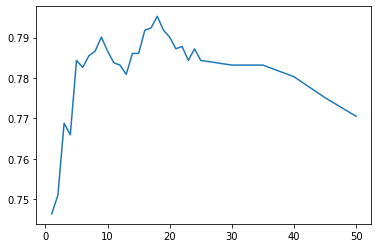

In [121]:
#4. KNN 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


n_neighbors_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22,23,24, 25, 30, 35, 40, 45, 50]
score = []

# 가장 적합한 k를 찾기.
for k in n_neighbors_list:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  score.append(knn.score(X_val, y_val))

plt.plot(n_neighbors_list, score)
print(n_neighbors_list[np.argmax(score)])


In [122]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, y_train)
print(knn.score(X_val, y_val))

0.7952846463484762


**KNN Classifier 를 사용했으며, 상수 k 를 변화시키면서 가장 최적화된 k 값을 먼저 찾았다. 그 결과 k=18 일 때 즉, 의사결정에 고려할 때 주변 18개의 instance 들을 사용할 때 가장 높은 성능을 기록한다는 것을 알 수 있었다. KNN classifier (k=18) 의 validation accuracy 는 0.795 였다.**

In [162]:
#5. Ensemble Model - Bagging 모델 

from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier



knn_clf = KNeighborsClassifier(n_neighbors = 18)
mlp_clf = MLPClassifier(hidden_layer_sizes=(16,8), activation='relu', 
                          batch_size=32, learning_rate_init=0.001, max_iter=50)
dt_clf = DecisionTreeClassifier(min_impurity_decrease = 0.001)


Ensemble_model_hard = VotingClassifier(estimators = [('KNN',knn_clf), ('MLP',mlp_clf), ('DT',dt_clf)], voting='hard')
Ensemble_model_soft = VotingClassifier(estimators = [('KNN',knn_clf), ('MLP',mlp_clf), ('DT',dt_clf)], voting='soft')


knn_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
Ensemble_model_hard.fit(X_train, y_train)
Ensemble_model_soft.fit(X_train, y_train)


print('KNN validation score : ', knn_clf.score(X_val, y_val))
print('MLP validation score : ', mlp_clf.score(X_val, y_val))
print('DT validtaion score : ', dt_clf.score(X_val, y_val))

print('Ensemble hard validation score : ', Ensemble_model_hard.score(X_val, y_val))
print('Ensemble soft validation score : ', Ensemble_model_soft.score(X_val, y_val))





/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


KNN validation score :  0.7952846463484762
MLP validation score :  0.8108108108108109
DT validtaion score :  0.7912593444508338
Ensemble hard validation score :  0.816561242093157
Ensemble soft validation score :  0.8113858539390454


**마지막 5번째 모델인 앙상블 모델은 지금까지 위에서 살펴보았던 모델 중, 높은 Validation accuracy 를 보였던 모델들로 구성하였다. 총 3개의 모델로 구성하였는데, 첫번째는 KNN classifier ( k = 18) 두번째는 hidden layer ( h_1 = 16, h_2 = 8 )가 2개인 Multi layer perceptron, 마지막으로 min_impurity_decrease = 0.001 으로, parameter 을 튜닝한 Decision Tree 이다. 앙상블 모델 중, 세 가지의 모델의 결과값을 반영하는 방식을 사용하였는데 다수결을 따르는 'hard' 방식, 확률 값을 계산하는 'soft' 방식에 대한 score 를 함께 살펴보았다. 그 결과 세 가지 모델을 독립적으로 사용했을 때의 validation accuracy 는 (KNN : 0.795, MLP : 0.811, DT : 0.791 ) 보다, 위 세가지의 모델을 하나로 묶어, 앙상블 모델로 구축했을 때 더 높은 validation accuracy ( 'hard' : 0.816, 'soft' : 0.811 ) 를 보인다는 점을 알 수 있었다. 그 중에서도, hard 방식의 정확도가 가장 높았다.** 



---

추가적으로 최종 모델의 accuracy 를 높이기 위하여, 모델에 최적화된 feature 를 산출하기 위하여 feature selection 을 진행하기로 하였다. 

In [258]:
print('Ensemble hard test score : ', Ensemble_model_hard.score(X_test, y_test))

Ensemble hard test score :  0.8125359401955147





> **5. 결론**

이번 텀 프로젝트를 통하여, Decision Tree, Perceptron, KNN, MLP, Ensemble 모델에 대한 각각의 validation score 를 살펴보았다. 
1. Decision Tree : min_impurity_decrease = 0.001 으로 튜닝한 Decision Tree 가 Decision Tree 중 가장 높은 validation score (0.792) 를 보였고, Feature selection 을 통해 24개의 feature 중 17개의 feature 를 사용할 때 성능이 더 증가하는 경향도 확인할 수 있었다. 

2. Perceptron : 퍼셉트론은 iteration 을 아무리 늘려도, validation score (0.719) 가 이 이상으로 증가하지 않는다는 것을 발견하였고, 이처럼 underfitted 되는 이유는 모델 구조가 단순하기 때문에 복잡한 데이터를 학습하기에는 빈약한 구조라는 점을 알게 되었다. 

3. KNN : KNN 은 가장 최적화된 k = 18 일 때, validation score (0.795) 로 가장 높은 수치가 나왔다. 

4. MLP : MLP 는 hiddenn layer 가 2개 일때 가장 높은 validation score (0.811) 를 도출했다. 단일 모델 중에서는 가장 높은 수치였으며, 단순히 layer 를 깊게하고, epochs 를 늘리는 것이 성능을 높이는 방법이 아니라는 것을 알 수 있었다. 모델 구조가 과하게 복잡해지고, epochs 가 증가하면서 overfitting 현상이 발생하였다. 

5. Ensemble model : 이전에 단일 모델로 높은 성능을 보인, KNN classifier ( k = 18), hidden layer ( h_1 = 16, h_2 = 8 )가 2개인 Multi layer perceptron, 그리고 min_impurity_decrease = 0.001 인 Decision Tree 총 3가지의 모델로 구성되었으며, 3개 아웃풋 다수결을 따르는 hard 방식의 앙상블 모델이다. validation score (0.816) 으로 가장 높았다. 

> 결국 최종적으로 앙상블 모델을 선택하였고, test accuracy 는 0.813 이였다.







